In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

# from matplotlib import pyplot as plt
# from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras

from scipy.stats import probplot
from scipy.stats import normaltest

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../dependencies/')

from plotting import *

In [2]:
import matplotlib as mpl
print(mpl.__version__)

3.2.1


In [3]:
inferenceLocations = ['Amazon-EC2','Desktop','Beaglebone']
inferenceLocationsBold = [r'\textbf{Amazon-EC2}',r'\textbf{Desktop}',r'\textbf{Beaglebone}']
basePath = 'data/Latency Tests/Results/'
numSamples = 700
numModels = 8

latencyVals = np.zeros((numSamples,numModels,len(inferenceLocations)))
scoreVals = np.zeros((numSamples,numModels,len(inferenceLocations)))
columns = None

In [4]:
for i in range(len(inferenceLocations)):
    thisDF = pd.read_csv(basePath + inferenceLocations[i] + '_Loaded_Train_Healthy.csv')
    
    print(thisDF.values.shape)
    
    if thisDF.values.shape[1] > 8:
        latencyVals[...,i] = thisDF.values[:,1:]
    else:
        latencyVals[...,i] = thisDF.values
    thisDF = pd.read_csv(basePath + inferenceLocations[i] + '_Loaded_Train_Healthy_values.csv')
    if thisDF.values.shape[1] > 8:
        scoreVals[...,i] = thisDF.values[:,1:]
    else:
        scoreVals[...,i] = thisDF.values
    if i == 0:
        columns = thisDF.columns[1:]
latencyVals *= 1e3

(700, 9)
(700, 8)
(700, 8)


In [5]:
print(np.mean(latencyVals[:,2,1]) - np.mean(latencyVals[:,3,1]))
print(np.amax(latencyVals[:,2,1]) - np.amax(latencyVals[:,3,1]))

print(np.mean(latencyVals[:,6,1]) - np.mean(latencyVals[:,7,1]))
print(np.amax(latencyVals[:,6,1]) - np.amax(latencyVals[:,7,1]))

print(np.mean(scoreVals[:,2,1]) - np.mean(scoreVals[:,3,1]))
print(np.amax(np.abs(scoreVals[:,2,1] - scoreVals[:,3,1])))

print(np.mean(scoreVals[:,6,1]) - np.mean(scoreVals[:,7,1]))
print(np.amax(np.abs(scoreVals[:,6,1] - scoreVals[:,7,1])))

312.62957298571274
884.0222699999921
200.66822429714037
507.38749600002825
-1.874286698066996e-10
2.2351741790771484e-08
-1.7029899712639462e-10
2.384185789905402e-07


mean latency, max latency, Max Score Difference, MSE

In [6]:
[colors[i] for i in np.arange(3)]

['#e41a1c', '#377eb8', '#4daf4a']

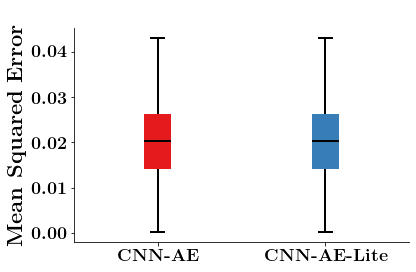

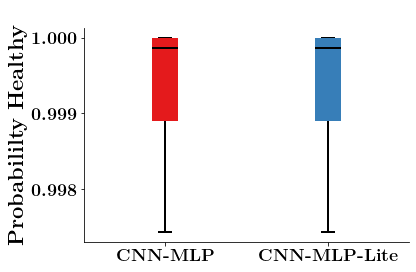

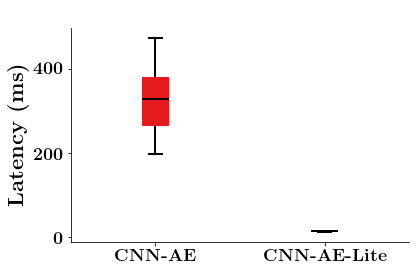

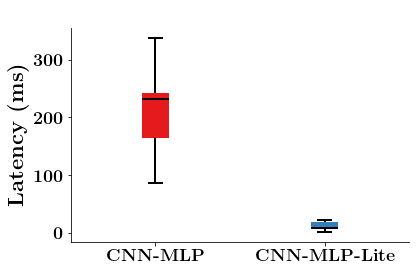

In [7]:
box_plot(scoreVals[:,np.array([2,3]),1],columns[np.array([2,3])],
         ylabel='Mean Squared Error',
        savefig=True,filename='CNN-AE_CompareScores_Boxplot',
        template='publication')

box_plot(scoreVals[:,np.array([6,7]),1],columns[np.array([6,7])],
         ylabel='Probabililty Healthy',
         savefig=True,filename='CNN-MLP_CompareScores_Boxplot',
         template='publication'
        )

box_plot(latencyVals[:,np.array([2,3]),1],columns[np.array([2,3])],
         savefig=True,filename='CNN-AE_CompareLatency_Boxplot',
         template='publication')
box_plot(latencyVals[:,np.array([6,7]),1],columns[np.array([6,7])],
         savefig=True,filename='CNN-MLP_CompareLatency_Boxplot',
         template='publication')


In [8]:
cloudLatencyND = latencyVals[:,np.array([0,2,3]),0]
cloudLatencyCLF = latencyVals[:,np.array([4,6,7]),0]

desktopLatencyND = latencyVals[:,np.array([0,2,3]),1]
desktopLatencyCLF = latencyVals[:,np.array([4,6,7]),1]

In [9]:
cloudLatencyCLF = np.expand_dims(cloudLatencyCLF,axis=1)
cloudLatencyND = np.expand_dims(cloudLatencyND,axis=1)

desktopLatencyCLF = np.expand_dims(desktopLatencyCLF,axis=1)
desktopLatencyND = np.expand_dims(desktopLatencyND,axis=1)

cloudLatency = np.hstack((cloudLatencyCLF,cloudLatencyND))
desktopLatency = np.hstack((desktopLatencyCLF,desktopLatencyND))

In [10]:
cloudLatency.shape

(700, 2, 3)

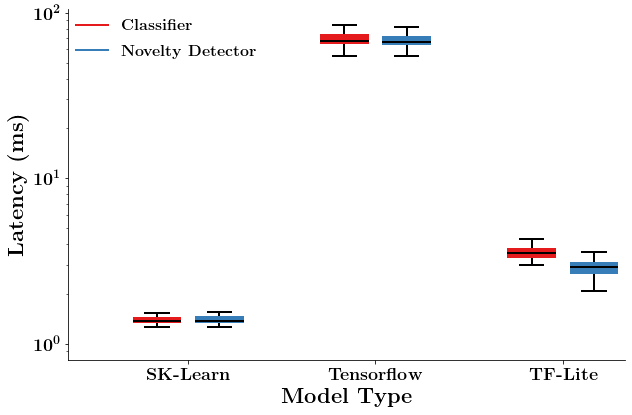

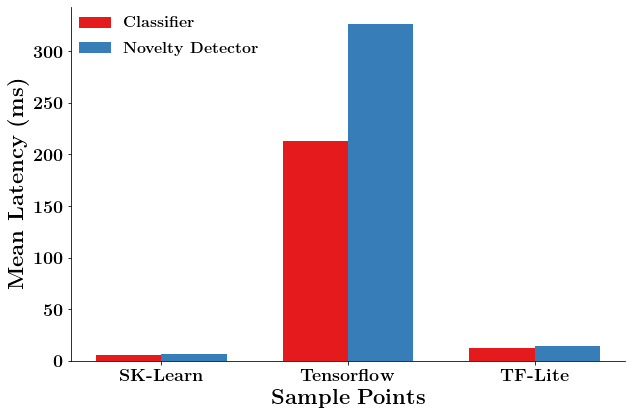

In [11]:
box_plot_compare((cloudLatency),['SK-Learn','Tensorflow','TF-Lite'],savefig=True,filename='Amazon-CompareLatency',
         template='presentation',xlabel='Model Type',color_order=np.zeros(6).astype(int),ylabel='Latency (ms)',
         showfliers=False,legend_loc='upper left',max_cutoff=2,plot_type='box',
         log_y=True,extension='svg',inferenceLocations=[r'\textbf{Classifier}',r'\textbf{Novelty Detector}'])

# box_plot_compare((desktopLatency),['SK-Learn','Tensorflow','TF-Lite'],savefig=True,filename='Desktop-CompareLatency',
#          template='presentation',xlabel='Model Type',color_order=np.zeros(6).astype(int),ylabel='Latency (ms)',
#          showfliers=False,legend_loc='upper left',max_cutoff=2,plot_type='box',
#          log_y=True,extension='svg',inferenceLocations=[r'\textbf{Classifier}',r'\textbf{Novelty Detector}'])

bar_chart_compare((desktopLatency),['SK-Learn','Tensorflow','TF-Lite'],[r'\textbf{Classifier}',r'\textbf{Novelty Detector}'],savefig=True,filename='Desktop-CompareLatency',
         template='presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int),ylabel='Mean Latency (ms)',
         showfliers=False,legend_loc='upper left',
         log_y=False,extension='svg',)

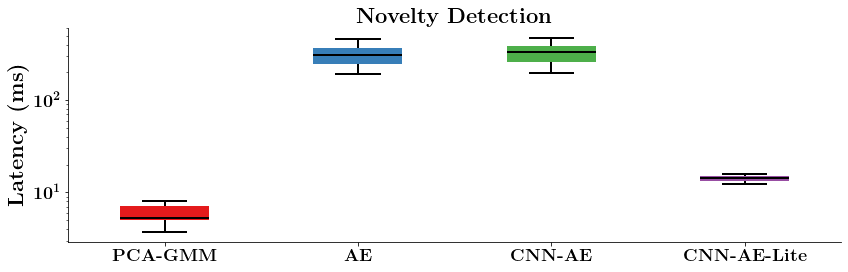

[6.5803168771415095, 310.141423459999, 326.5505999142847, 13.921026928571965]


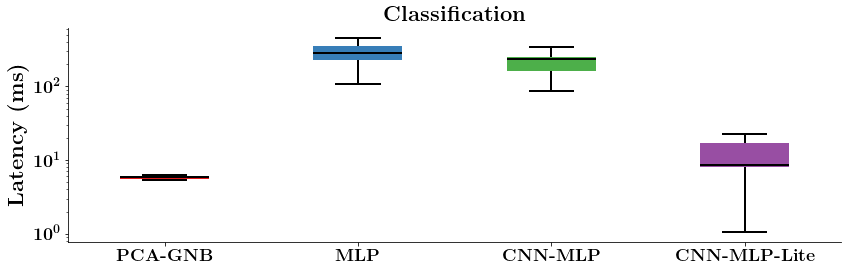

In [12]:
box_plot(latencyVals[:,:4,1],columns[:4],savefig=True,
         filename='Desktop_Latency_Anomaly_Boxplot',template='Wide',log_y=True,
         title='Novelty Detection'
         )


print([np.mean(latencyVals[:,i,1]) for i in range(4)])

box_plot(latencyVals[:,4:,1],columns[4:],savefig=True,filename='Desktop_Latency_Classification_Boxplot',
         template='wide',log_y=True,title='Classification')

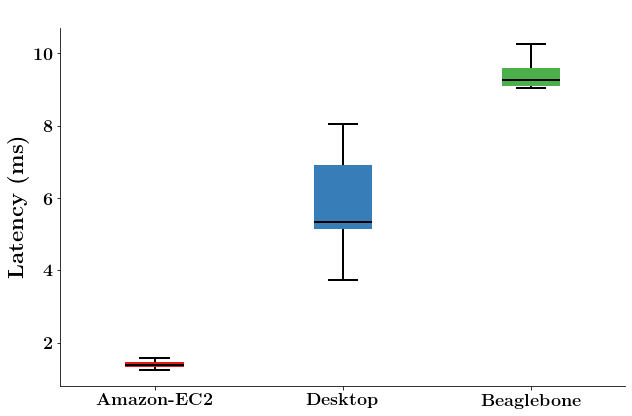

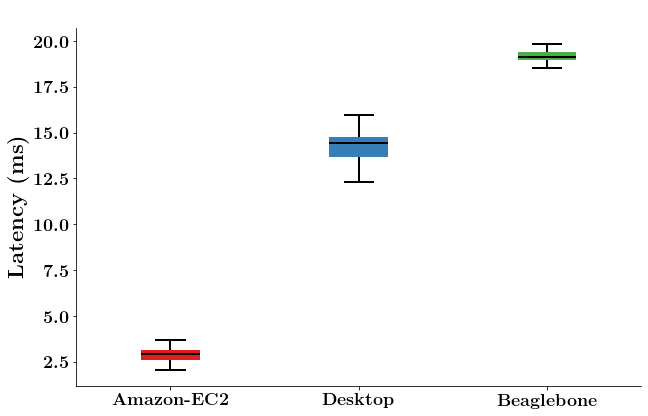

In [13]:

box_plot(latencyVals[:,0,:],inferenceLocationsBold,savefig=True,filename='PCA-GMM_Boxplot',template='Presentation')
box_plot(latencyVals[:,3,:],inferenceLocationsBold,savefig=True,filename='CNN-AE-Lite_Boxplot',template='Presentation')

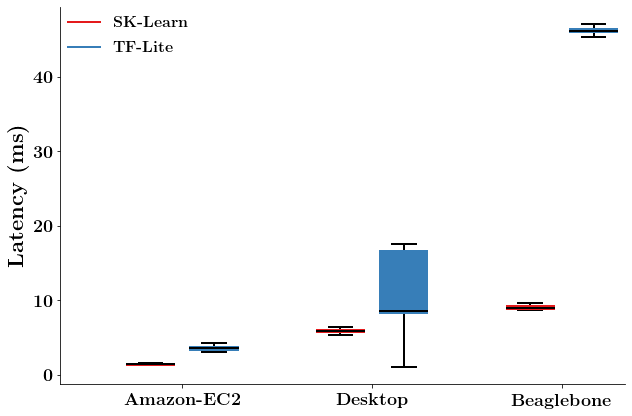

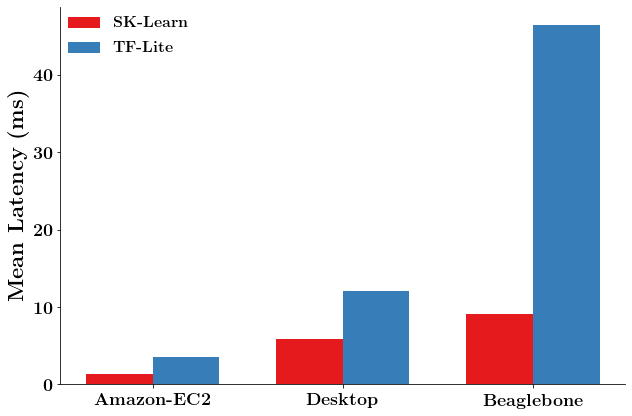

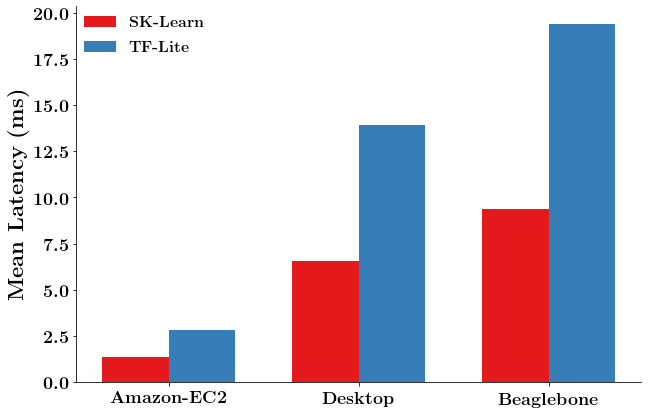

In [16]:
box_plot_compare((latencyVals[:,np.array([4,7]),:]),inferenceLocationsBold,savefig=True,filename='Classifier-CompareLatency',
         template='presentation',xlabel='',color_order=np.zeros(6).astype(int),ylabel='Latency (ms)',
         showfliers=False,legend_loc='upper left',max_cutoff=2,plot_type='box',
         log_y=False,extension='svg',inferenceLocations=[r'\textbf{SK-Learn}',r'\textbf{TF-Lite}'])

bar_chart_compare((latencyVals[:,np.array([4,7]),:]),inferenceLocationsBold,[r'\textbf{SK-Learn}',r'\textbf{TF-Lite}'],savefig=True,filename='Classifier-CompareLatency',
         template='presentation',xlabel='',color_order=np.zeros(6).astype(int),ylabel='Mean Latency (ms)',
         showfliers=False,legend_loc='upper left',
         log_y=False,extension='svg',)

bar_chart_compare((latencyVals[:,np.array([0,3]),:]),inferenceLocationsBold,[r'\textbf{SK-Learn}',r'\textbf{TF-Lite}'],savefig=True,filename='ND-CompareLatency',
         template='presentation',xlabel='',color_order=np.zeros(6).astype(int),ylabel='Mean Latency (ms)',
         showfliers=False,legend_loc='upper left',
         log_y=False,extension='svg',)